In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/textdb3/fake_or_real_news.csv


In [2]:
news = pd.read_csv('../input/textdb3/fake_or_real_news.csv')

In [3]:
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
len(news)

6335

In [5]:
news.isnull().any()

Unnamed: 0    False
title         False
text          False
label         False
dtype: bool

In [6]:
news['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

Analysis 1 : 
* Real and Fake news are almost equally distributed.
* We have three fields title, text and label
* We have 6335 items
* No Value is null

In [7]:
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import TfidfModel

In [8]:
def lemmatize_list(lis):
    """
    Used to Lemmatize list of words
    
    :param lis: list of words to lemmatize
    :returns: list of lemmatized words
    :rtype: list
    """
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in lis]

In [9]:
news['cleaned_title'] = news['title'].apply(simple_preprocess).apply(lemmatize_list)

In [10]:
news.head()

,Unnamed: 0,title,text,label,cleaned_title
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[you, can, smell, hillary, fear]"
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[watch, the, exact, moment, paul, ryan, commit..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,"[kerry, to, go, to, paris, in, gesture, of, sy..."
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,"[bernie, supporter, on, twitter, erupt, in, an..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,"[the, battle, of, new, york, why, this, primar..."


In [11]:
%matplotlib inline

from wordcloud import WordCloud

all_words = ' '.join([text for text in news.title])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

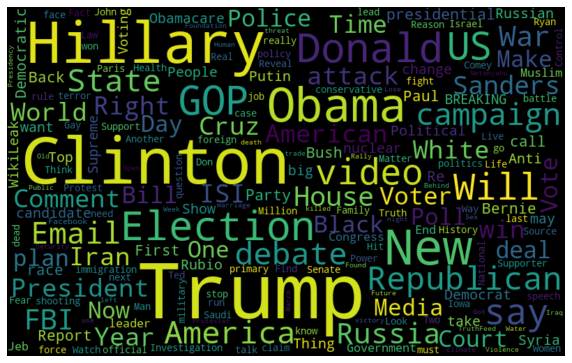

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
dictionary = corpora.Dictionary(news['cleaned_title'])

In [14]:
dictionary[1]

'fear'

In [15]:
bag_of_words = [dictionary.doc2bow(title) for title in news.cleaned_title]

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

#Creating the bag of words
bow_title = CountVectorizer().fit(news['title'])

In [37]:
title_vect = bow_title.transform(news['title'])
# bow_title['You Can Smell Hillary’s Fear']
# news['title'][0]

In [41]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(title_vect)
news_tfidf = tfidf_transformer.transform(title_vect)
print(news_tfidf.shape)

(6335, 10071)


In [38]:
# tfidf_model = TfidfModel(bag_of_words)

In [39]:
# titles_tfidf = [tfidf_model[bag_of_words[ind]] for ind in range(0,len(bag_of_words))]

In [40]:
# titles_tfidf[0]

In [47]:
X = news_tfidf
y = news['label']

In [48]:
# X = [[tup[1] for tup in lis] for lis in X]

In [49]:
X[0]

<1x10071 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,Y_test= train_test_split(X, y, test_size=0.2, random_state=1)

In [51]:
from sklearn.svm import SVC
model = SVC()
detector = model.fit(X_train, Y_train)


In [52]:
predictions = detector.predict(X_test)
print(predictions)

['FAKE' 'FAKE' 'REAL' ... 'REAL' 'REAL' 'REAL']


In [53]:
from sklearn.metrics import classification_report
print (classification_report(Y_test, predictions))

              precision    recall  f1-score   support

        FAKE       0.82      0.86      0.84       651
        REAL       0.85      0.80      0.82       616

    accuracy                           0.83      1267
   macro avg       0.83      0.83      0.83      1267
weighted avg       0.83      0.83      0.83      1267



In [54]:
from sklearn.linear_model import SGDClassifier

fake_detector_svc = SGDClassifier().fit(X_train, Y_train)

In [55]:
prediction_svc = fake_detector_svc.predict(X_test)

In [56]:
print (classification_report(Y_test, prediction_svc))

              precision    recall  f1-score   support

        FAKE       0.82      0.82      0.82       651
        REAL       0.81      0.81      0.81       616

    accuracy                           0.81      1267
   macro avg       0.81      0.81      0.81      1267
weighted avg       0.81      0.81      0.81      1267

